In [1]:
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
import psycopg2

# from config import db_password

import time

In [2]:
#  Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles
    return movie

In [3]:
# 1 Add the function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load():
    # Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    file_dir = 'D:\Mohammad-Assaad\Data-Analytics-Boot-Camp\Module-8-ETL-Extrat-Trandsform-Load\Movies-ETL'
    # The Wikipedia data
    kaggle_metadata = pd.read_csv(f'{file_dir}\movies_metadata.csv', low_memory=False)
    ratings = pd.read_csv(f'{file_dir}\\ratings.csv')   

    # Open and read the Wikipedia data JSON file.
    wiki_file = f'{file_dir}\\wikipedia-movies.json'
    with open(wiki_file, mode='r') as file:
        wiki_movies_raw = json.load(file)    

    # Write a list comprehension to filter out TV shows.
    wiki_movies = [movie for movie in wiki_movies_raw	if ('Director' in movie or 'Directed by' in movie) and 'imdb_link' in movie and 'No. of episodes' not in movie]


    # Write a list comprehension to iterate through the cleaned wiki movies list
    # and call the clean_movie function on each movie.
    clean_movies = [clean_movie(movie) for movie in wiki_movies]    

    # Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df = pd.DataFrame(clean_movies)

    # Write a try-except block to catch errors while extracting the IMDb ID using a regular expression string and
    #  dropping any imdb_id duplicates. If there is an error, capture and print the exception.
    try:
        wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
        wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
    except Exception as e:
        print(e)

    # Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.
    wiki_columns_to_keep = [[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]    

    # Create a variable that will hold the non-null values from the “Box office” column.
    # box_office = wiki_columns_to_keep["Box office"]

    # Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office = wiki_movies_df['Box office'].dropna()
    box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)   

    # Write a regular expression to match the six elements of "form_one" of the box office data.
    form_one = r'\$\d+\.?\d*\s*[mb]illion'   
    # Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two = r'\$\d{1,3}(?:,\d{3})+'    

    # Add the parse_dollars function.
    def parse_dollars(s):
        # if s is not a string, return NaN
        if type(s) != str:
            return np.nan

        # if input is of the form $###.# million
        if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " million"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a million
            value = float(s) * 10**6

        # return value
            return value

    # if input is of the form $###.# billion
        elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " billion"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a billion
            value = float(s) * 10**9

        # return value
            return value

    # if input is of the form $###,###,###
        elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

            # remove dollar sign and commas
            s = re.sub('\$|,','', s)

            # convert to float
            value = float(s)

        # return value
            return value

    # otherwise, return NaN
        else:
            return np.nan    

    # Clean the box office column in the wiki_movies_df DataFrame.
    wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    wiki_movies_df.drop('Box office', axis=1, inplace=True)

        # Clean the budget column in the wiki_movies_df DataFrame.
    budget = wiki_movies_df['Budget'].dropna()
    budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
    matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
    budget[~matches_form_one & ~matches_form_two]
    budget = budget.str.replace(r'\[\d+\]\s*', '')
    budget[~matches_form_one & ~matches_form_two]
    wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    wiki_movies_df.drop('Budget', axis=1, inplace=True)    

    # Clean the release date column in the wiki_movies_df DataFrame.
    release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

    date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
    date_form_two = r'\d{4}.[01]\d.[123]\d'
    date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    date_form_four = r'\d{4}'

    release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

    wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)    

    # Clean the running time column in the wiki_movies_df DataFrame.
    running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)	

    running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE).sum()	
    running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE) != True]	

    running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE).sum()	
    running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE) != True]	

    running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')	

    running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)		

    wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
    wiki_movies_df.drop('Running time', axis=1, inplace=True)    

    # 2. Clean the Kaggle metadata.
    kaggle_metadata.dtypes

    kaggle_metadata['adult'].value_counts()
    kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]
    kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

    kaggle_metadata['video'].value_counts()
    kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

    kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
    kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
    kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
    kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

    ratings.info(null_counts=True)
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

    pd.options.display.float_format = '{:20,.2f}'.format
    ratings['rating'].plot(kind='hist')
    ratings['rating'].describe()

        # 3. Merged the two DataFrames into the movies DataFrame.
    movies_df=pd.merge(wiki_movies_df,kaggle_metadata,on='imdb_id',suffixes=['_wiki','_kaggle'])

        # 4. Drop unnecessary columns from the merged DataFrame.
    movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)

        # 5. Add in the function to fill in the missing Kaggle data.
    def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
        df[kaggle_column] = df.apply(
            lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
            , axis=1)
        df.drop(columns=wiki_column, inplace=True)

    # 6. Call the function in Step 5 with the DataFrame and columns as the arguments.
    fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
    fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
    fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')

    # 7. Filter the movies DataFrame for specific columns.
    # movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
        # 'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
        # 'genres','original_language','overview','spoken_languages','Country',
        # 'production_companies','production_countries','Distributor',
        # 'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
        # ]]
    movies_df = movies_df.reindex(columns=['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
        'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
        'genres','original_language','overview','spoken_languages','Country',
        'production_companies','production_countries','Distributor',
        'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'])

    # 8. Rename the columns in the movies DataFrame.
    movies_df.rename({'id':'kaggle_id',
    'title_kaggle':'title',
    'url':'wikipedia_url',
    'budget_kaggle':'budget',
    'release_date_kaggle':'release_date',
    'Country':'country',
    'Distributor':'distributor',
    'Producer(s)':'producers',
    'Director':'director',
    'Starring':'starring',
    'Cinematography':'cinematography',
    'Editor(s)':'editors',
    'Writer(s)':'writers',
    'Composer(s)':'composers',
    'Based on':'based_on'
    }, axis='columns', inplace=True)              

    # 9. Transform and merge the ratings DataFrame.
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                    .rename({'userId':'count'}, axis=1) \
                    .pivot(index='movieId',columns='rating', values='count')
    rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]
    movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')

    return wiki_movies_df, movies_with_ratings_df, movies_df


<ipython-input-3-df5a29b26171>:107: FutureWarning: The default value of regex will change from True to False in a future version.
  budget = budget.str.replace(r'\[\d+\]\s*', '')
<ipython-input-3-df5a29b26171>:155: FutureWarning: null_counts is deprecated. Use show_counts instead
  ratings.info(null_counts=True)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


 On the Basis of Sex   
 7074  https://www.imdb.com/title/tt7137380/                        Destroyer   
 7075  https://www.imdb.com/title/tt9495224/                     Bandersnatch   
 
              Directed by                                        Produced by  \
 0           Renny Harlin                         [Steve Perry, Joel Silver]   
 1            James Foley                        [Ric Kidney, Robert Redlin]   
 2     Roger Spottiswoode                                     Daniel Melnick   
 3            Woody Allen                                    Robert Greenhut   
 4           John Cornell                                       John Cornell   
 ...                  ...                                                ...   
 7071          Etan Cohen  [Will Ferrell, Adam McKay, Jimmy Miller, Clayt...   
 7072          Adam McKay  [Brad Pitt, Dede Gardner, Jeremy Kleiner, Kevi...   
 7073          Mimi Leder                                     Robert W. Cort   
 7074       

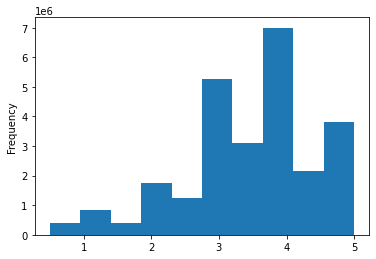

In [4]:
extract_transform_load()

In [5]:
# 10. Create the path to your file directory and variables for the three files.
file_dir = '../Resources'
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia.movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

In [6]:
file_dir

'../Resources'

<ipython-input-3-df5a29b26171>:107: FutureWarning: The default value of regex will change from True to False in a future version.
  budget = budget.str.replace(r'\[\d+\]\s*', '')
<ipython-input-3-df5a29b26171>:155: FutureWarning: null_counts is deprecated. Use show_counts instead
  ratings.info(null_counts=True)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


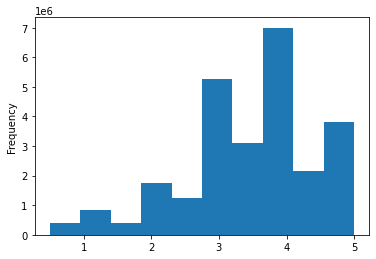

In [7]:
# 11. Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = extract_transform_load()

In [8]:
# 12. Set the DataFrames from the return statement equal to the file names in Step 11. 
wiki_movies_df = wiki_file
movies_with_ratings_df = kaggle_file
movies_df = ratings_file

In [9]:
# 13. Check the wiki_movies_df DataFrame. 
wiki_movies_df.head()

,url,year,imdb_link,title,Directed by,Produced by,Screenplay by,Story by,Based on,Starring,...,Director,Producer,Animation by,Color process,Screen story by,imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,Renny Harlin,"[Steve Perry, Joel Silver]","[David Arnott, James Cappe, Daniel Waters]","[David Arnott, James Cappe]","[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",...,NaN,NaN,NaN,NaN,NaN,tt0098987,"21,400,000.00","20,000,000.00",1990-07-11,102.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet",James Foley,"[Ric Kidney, Robert Redlin]","[James Foley, Robert Redlin]",NaN,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",...,NaN,NaN,NaN,NaN,NaN,tt0098994,"2,700,000.00","6,000,000.00",1990-05-17,114.00
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,Roger Spottiswoode,Daniel Melnick,"[John Eskow, Richard Rush]",NaN,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",...,NaN,NaN,NaN,NaN,NaN,tt0099005,"57,718,089.00","35,000,000.00",1990-08-10,113.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,Woody Allen,Robert Greenhut,NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",...,NaN,NaN,NaN,NaN,NaN,tt0099012,"7,331,647.00","12,000,000.00",1990-12-25,106.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,John Cornell,John Cornell,NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",...,NaN,NaN,NaN,NaN,NaN,tt0099018,"6,939,946.00","25,000,000.00",1990-12-19,95.00


In [10]:
# 14. Check the movies_with_ratings_df DataFrame.
movies_with_ratings_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.00,"49,000,000.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.00,"6,000,000.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.00,"35,000,000.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.00,"12,000,000.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.00,"25,000,000.00",...,3.00,NaN,3.00,2.00,5.00,26.00,37.00,46.00,16.00,11.00


In [11]:
# 15. Check the movies_df DataFrame. 
movies_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,production_countries,distributor,producers,director,starring,cinematography,editors,writers,composers,based_on
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.00,"49,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,NaN,NaN,NaN,"[Characters, by Rex Weiner]"
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.00,"6,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,NaN,NaN,NaN,"[the novel, After Dark, My Sweet, by, Jim Thom..."
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.00,"35,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,NaN,NaN,NaN,"[Air America, by, Christopher Robbins]"
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.00,"12,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,NaN,NaN,NaN,NaN
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.00,"25,000,000.00",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,NaN,NaN,NaN,NaN
